<h1>
<div class = "alert alert-info">
<dt>Sentiment Analysis and recommendation on Amazon's Electronics Dataset</dt>
</div>
</h1>

## purpose
1. 
2. 

<font size="+1.5">
<div class="alert alert-block alert-warning">
<dt>Data Import</dt>
</div>
</font>

In [1]:
# return all results in the cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import gzip
import json
import pprint

import contractions
import re

import string
punctuations = string.punctuation
# removed '!' and '?'
revised_punct = '"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'

# loading the nlp model
import spacy
nlp = spacy.load("en_core_web_sm", disable=["textcat", 
                                            "textcat_multilabel", 
                                            "entity_linker", "custom"])

from spacy.tokenizer import Tokenizer

# Creating a Spacy Parser -- Eng
from spacy.lang.en import English
parser = English()

# getting stopwords from spacy 
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = list(STOP_WORDS)

from spacymoji import Emoji
emoji = Emoji(nlp)
nlp.add_pipe('emoji', first=True)


In [3]:
# save the json file path
file_name = "Electronics.json"

In [4]:
# read the json file line by line
class json__generator_pipeline:
        
    # initialize all parameters
    '''
    file_name is where we save the file path as above
    print_lines is a parameter to determine how many data can be shown if the data and the class works well
    save_lines is a parameter to decide how many data you generate from the json file
    '''
    def __init__(self, file_name, print_lines=1, save_lines= 29999):
        self.file_name = file_name
        self.print_lines = print_lines
        self.save_lines = save_lines
        
    # get the file object
    def read_json_file(self):
        file_object = open(self.file_name, 'r')
        return file_object

    # get the generator to load data
    def get_generator(self):
        file_object = self.read_json_file()
        while True:
            line = file_object.readline()
            if len(line) == 0:
                break
            data = json.loads(line)
            yield data
    
    # print the data to see if the class works well
    def print_data(self):
        data_generator = self.get_generator()
        num_lines = 0
        for tmp in data_generator:
            if num_lines == self.print_lines:
                break
            num_lines += 1
            pprint.pprint(tmp)
            print()
    
    # save the data for the following manipulation
    def save_data(self):
        data_generator = self.get_generator()
        data = []
        num_lines = 0
        for temp in data_generator:
            num_lines += 1
            data.append(temp)
            if num_lines == self.save_lines:
                break
        return data

# implement the class, print_data function, and raw_data for next step
load_class = json__generator_pipeline(file_name=file_name)
print_data = load_class.print_data()
raw_data = load_class.save_data()

{'asin': '0060009810',
 'overall': 5.0,
 'reviewText': 'This was the first time I read Garcia-Aguilera.  I came upon '
               'the name of this book on Live with Regis and Kelly. This book '
               'was exactly what I was looking for ... it hit the spot.  I '
               'really enjoyed this book because it was well written. Once I '
               'started this book it kept me coming back for more. It had '
               'culture, family, friendship and romance. I was looking for a '
               'little more romance when I picked this book but in the end it '
               'turned out to be just right.  I love the main chartachter '
               "Margarita (aka Daisy). I've never been to Miami but the way "
               "Daisy told the story I certainly felt I'd been there.\n"
               "Also after going through all of Daisy's perils ... I closed "
               'the book with a feeling I had grown emotionally as well.',
 'reviewTime': '07 17, 2002',


In [5]:
# transform the json object to dataframe
df = pd.json_normalize(raw_data)
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style.Format:,...,style.Color:,style.Size:,style.Capacity:,style.Size Name:,style.Product Packaging:,style.Package Type:,style.Style:,style.Style Name:,style.Length:,style.Model:
0,5.0,True,"07 17, 2002",A1N070NS9CJQ2I,0060009810,Teri Adams,This was the first time I read Garcia-Aguilera...,Hit The Spot!,1026864000,Hardcover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.0,False,"07 6, 2002",A3P0KRKOBQK1KN,0060009810,Willa C.,"As with all of Ms. Garcia-Aguilera's books, I ...",one hot summer is HOT HOT HOT!,1025913600,Hardcover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.0,False,"07 3, 2002",A192HO2ICJ75VU,0060009810,Kit,I've not read any of Ms Aguilera's works befor...,One Hot Summer,1025654400,Hardcover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,False,"06 30, 2002",A2T278FKFL3BLT,0060009810,Andres,This romance novel is right up there with the ...,I love this book!,1025395200,Hardcover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,False,"06 28, 2002",A2ZUXVTW8RXBXW,0060009810,John,Carolina Garcia Aguilera has done it again. S...,One Hot Book,1025222400,Hardcover,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# show the num counts
# when data count is too many, it may not be shown. show_counts is the parameter to show the data count no matter how many
df.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29999 entries, 0 to 29998
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall                   29999 non-null  float64
 1   verified                  29999 non-null  bool   
 2   reviewTime                29999 non-null  object 
 3   reviewerID                29999 non-null  object 
 4   asin                      29999 non-null  object 
 5   reviewerName              29998 non-null  object 
 6   reviewText                29992 non-null  object 
 7   summary                   29995 non-null  object 
 8   unixReviewTime            29999 non-null  int64  
 9   style.Format:             7723 non-null   object 
 10  vote                      4966 non-null   object 
 11  image                     101 non-null    object 
 12  style.Color:              3548 non-null   object 
 13  style.Size:               1896 non-null   object 
 14  style.

In [7]:
# only get the text reviewtest and rating columns as a new dataframe 'review_df'
review_df = df[['reviewText', 'overall']]
review_df = review_df.rename(columns={'overall': 'Rating'})

# set index as column number into dataframe
review_df['ID'] = review_df.index
review_df = review_df[['ID', 'reviewText', 'Rating']]
review_df.head()

,ID,reviewText,Rating
0,0,This was the first time I read Garcia-Aguilera...,5.0
1,1,"As with all of Ms. Garcia-Aguilera's books, I ...",5.0
2,2,I've not read any of Ms Aguilera's works befor...,5.0
3,3,This romance novel is right up there with the ...,4.0
4,4,Carolina Garcia Aguilera has done it again. S...,5.0


In [8]:
# check if any Null value
review_df.isnull().sum()

ID            0
reviewText    7
Rating        0
dtype: int64

In [9]:
# drop the Null value if it's not many
review_df = review_df.dropna()

# check if the Null value is deleted
review_df.isnull().sum()
review_df.count()

# need to reindex 
review_df.reset_index(drop=True, inplace=True)

ID            0
reviewText    0
Rating        0
dtype: int64

ID            29992
reviewText    29992
Rating        29992
dtype: int64

In [10]:
# reviewtext is a emoji, need to deal with later
df.iloc[12770:12771, :7]

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText
12770,5.0,True,"11 2, 2014",A1LVTDDHV6AT4M,6073894996,Shayla Rideaux,:)


In [11]:
# URL Counts
pattern =  r'(?:http://)?\w+\.\S*[^.\s]'
tweet = ('PyBites My Reading List | 12 Rules for Life - #books '
             'that expand the mind! '
             'www.google.com/telephone/wire....  '
             'http://pbreadinglist.herokuapp.com/books/'
             'TvEqDAAAQBAJ#.XVOriU5z2tA.twitter '
             "http://-www.pip.org "
             "google.com "
             "twitter.com "
             "facebook.com"
             ' #psychology #philosophy')

re.findall(pattern, tweet)

# 'Yes' represents the comment includes URL, 'No' means it doesn't have
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : re.sub(pattern, "", string))

['www.google.com/telephone/wire',
 'http://pbreadinglist.herokuapp.com/books/TvEqDAAAQBAJ#.XVOriU5z2tA.twitter',
 'www.pip.org',
 'google.com',
 'twitter.com',
 'facebook.com']

In [12]:
# Accented Chars Counts
import unicodedata
def remove_acc_data(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

# 'Yes' represents the comment has Accented Chars, 'No' means it doesn't have
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : remove_acc_data(string))


In [13]:
# remove multiple spaces in the comments
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : " ".join(string.split()))

In [14]:
# expand the short forms, expecailly "'ve" to have that can not achieve in the sapcy
review_df['reviewText'] = review_df['reviewText'].apply(lambda string : contractions.fix(string))

In [15]:
%%time
review_df['revised'] = review_df['reviewText'].apply(lambda string: nlp(string))

Wall time: 4min 38s


In [16]:
tags = ['JJR', 'JJS', 'RBR', 'RBS']
def get_tags(text):
    res = []
    for token in text:
        if token.tag_ in tags:
            res.append(token.lower_)
        else:
            res.append(token.lemma_.lower())
    return res
        
# lemma = lambda text: " ".join([token.lower_ for token in text
#                                if token.lemma_ in tags 
#                                else token.lemma_.lower()])


In [17]:
review_df['revised1'] = review_df['revised'].apply(lambda doc: get_tags(doc))

In [18]:
def punctuations_remover(text):
    res = []
    '''remove the punctuations of each comment'''
#         punct_string_list = []
    for token in text:
        if token not in revised_punct:
            res.append(token)
    return res

In [19]:
review_df['revised2'] = review_df['revised1'].apply(lambda doc: punctuations_remover(doc))

In [20]:
def stopwords_remover(text):
    stpw_string = []
        
    for token in text:
        if token not in stopwords:
            stpw_string.append(token)
    return stpw_string

In [21]:
review_df['revised3'] = review_df['revised2'].apply(lambda doc: stopwords_remover(doc))

In [22]:
# phrase modeling using noun chunk and named entity

In [23]:
def named_entity(text):
    res = []
    for ent in text.ents:
        res.append(ent.text.lower())
    return res

In [24]:
review_df['revised4'] = review_df['revised'].apply(lambda doc: named_entity(doc))

In [25]:
def name_chunk(text):
    res = []
    for chunk in text.noun_chunks:
        res.append(chunk.text.lower())
    return res

In [26]:
review_df['revised5'] = review_df['revised'].apply(lambda doc: name_chunk(doc))

In [27]:
def name_chunk_add(review_df):
    try:
        
        comparison_candidate = review_df['revised3']
        need_to_compare = review_df['revised4'] + review_df['revised5']
        res = comparison_candidate

        for index, noun_list in enumerate(need_to_compare):
            for token in noun_list:
                if token not in set(comparison_candidate[index]):
                    res[index].append(token)
        return res
    
    except KeyError:
        return res

In [28]:
review_df['revised6'] = name_chunk_add(review_df)

In [29]:
tokenized = review_df['revised6']

In [30]:
# TF-IDF

In [31]:
from gensim.corpora.dictionary import Dictionary

vocabulary = Dictionary(tokenized)
vocabulary.filter_extremes(no_below=20, no_above=0.2)
vocabulary.compactify()

vocabulary_keys = list(vocabulary.token2id)[0:10]

for key in vocabulary_keys:
    print(f"ID: {vocabulary.token2id[key]}, Token: {key}")

ID: 0, Token: ...
ID: 1, Token: all
ID: 2, Token: book
ID: 3, Token: certainly
ID: 4, Token: close
ID: 5, Token: come
ID: 6, Token: culture
ID: 7, Token: end
ID: 8, Token: enjoy
ID: 9, Token: exactly


In [32]:
bow = [vocabulary.doc2bow(doc) for doc in tokenized]

for idx, freq in bow[0]:
    print(f"Word: {vocabulary.get(idx)}, Frequency: {freq}")

Word: ..., Frequency: 2
Word: all, Frequency: 1
Word: book, Frequency: 6
Word: certainly, Frequency: 1
Word: close, Frequency: 1
Word: come, Frequency: 2
Word: culture, Frequency: 1
Word: end, Frequency: 1
Word: enjoy, Frequency: 1
Word: exactly, Frequency: 1
Word: exactly what, Frequency: 1
Word: family, Frequency: 1
Word: feel, Frequency: 1
Word: feeling, Frequency: 1
Word: first, Frequency: 1
Word: friendship, Frequency: 1
Word: grow, Frequency: 1
Word: hit, Frequency: 1
Word: little, Frequency: 1
Word: live, Frequency: 1
Word: look, Frequency: 2
Word: love, Frequency: 1
Word: main, Frequency: 1
Word: me, Frequency: 1
Word: pick, Frequency: 1
Word: read, Frequency: 1
Word: right, Frequency: 1
Word: romance, Frequency: 2
Word: spot, Frequency: 1
Word: start, Frequency: 1
Word: story, Frequency: 1
Word: tell, Frequency: 1
Word: the book, Frequency: 1
Word: the end, Frequency: 1
Word: the first time, Frequency: 1
Word: the name, Frequency: 1
Word: the story, Frequency: 1
Word: this boo

In [33]:
# 越大越重要
from gensim.models.tfidfmodel import TfidfModel

tfidf = TfidfModel(bow, id2word=vocabulary)


for idx, weight in tfidf[bow[0]]:
    print(f"Word: {vocabulary.get(idx)}, Weight: {weight:.3f}")

Word: ..., Weight: 0.213
Word: all, Weight: 0.101
Word: book, Weight: 0.372
Word: certainly, Weight: 0.163
Word: close, Weight: 0.146
Word: come, Weight: 0.168
Word: culture, Weight: 0.204
Word: end, Weight: 0.105
Word: enjoy, Weight: 0.104
Word: exactly, Weight: 0.119
Word: exactly what, Weight: 0.140
Word: family, Weight: 0.130
Word: feel, Weight: 0.110
Word: feeling, Weight: 0.180
Word: first, Weight: 0.094
Word: friendship, Weight: 0.229
Word: grow, Weight: 0.172
Word: hit, Weight: 0.166
Word: little, Weight: 0.091
Word: live, Weight: 0.136
Word: look, Weight: 0.163
Word: love, Weight: 0.070
Word: main, Weight: 0.142
Word: me, Weight: 0.071
Word: pick, Weight: 0.144
Word: read, Weight: 0.065
Word: right, Weight: 0.101
Word: romance, Weight: 0.307
Word: spot, Weight: 0.173
Word: start, Weight: 0.108
Word: story, Weight: 0.093
Word: tell, Weight: 0.118
Word: the book, Weight: 0.109
Word: the end, Weight: 0.139
Word: the first time, Weight: 0.184
Word: the name, Weight: 0.220
Word: th

In [38]:
docs_tfidf = tfidf[bow]
from gensim.matutils import sparse2full

In [39]:


%%time
docs_vecs = np.vstack([sparse2full(c, len(vocabulary)) for c in docs_tfidf])

Wall time: 3.85 s


In [40]:
docs_vecs.shape

(29992, 4204)

In [41]:
tfidf_emb_vecs = np.vstack([nlp(vocabulary[i]).vector for i in range(len(vocabulary))])

In [42]:
docs_emb = np.dot(docs_vecs, tfidf_emb_vecs)

In [43]:
model_df = pd.DataFrame(docs_emb)
model_df["label"] = review_df["Rating"]

display(model_df.head())

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
0,-3.601439,-1.770129,0.828240,3.136814,0.628571,-0.473668,0.754293,2.382292,-0.537073,0.881045,...,1.144396,-3.309823,2.719319,-3.697955,-0.459356,-3.944164,1.279042,5.387758,0.855537,5.0
1,-1.274574,-0.455472,1.005303,1.839584,-0.825846,-0.047031,-0.863877,0.885698,-0.469241,0.246084,...,-0.095595,-2.017393,0.105093,-0.005399,-0.425737,-0.791213,0.128742,3.363104,0.291746,5.0
2,-1.462592,-0.887505,1.012609,2.597141,-0.559633,-0.265757,-0.758742,1.589096,-0.394466,-0.165940,...,0.224130,-1.532296,1.565509,-2.085473,-1.226805,-2.048778,1.024119,2.553920,0.522945,5.0
3,-3.090636,-1.712740,0.761669,2.023111,-0.854057,-0.240116,-1.563805,1.705331,-0.343800,0.622006,...,0.241976,-2.823102,1.050382,-1.345169,-1.136097,-2.934935,1.746148,4.792614,0.522340,4.0
4,-1.496743,-0.946508,0.340624,2.104641,0.010486,-0.134180,-1.620080,1.128461,-0.829537,-0.133806,...,-0.327180,-1.335244,0.975308,-1.529914,-1.290372,-0.467403,0.242588,2.677001,-0.178187,5.0


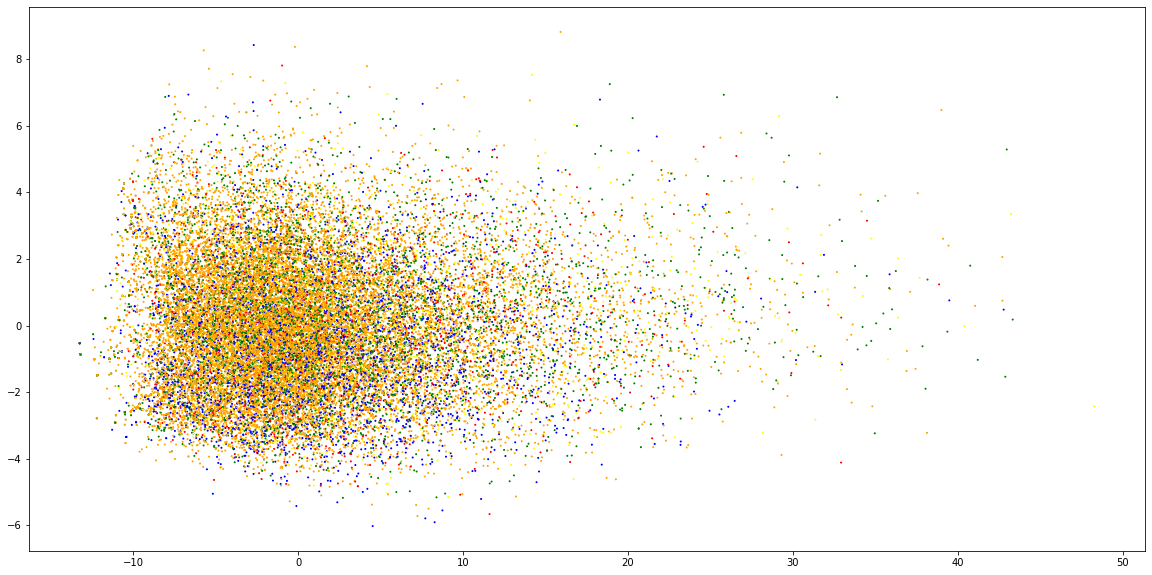

In [44]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

#sampling the model_df population
pca_df = model_df.reset_index()
pca_df = model_df.dropna(axis=0).iloc[:,1:]
# pca_df = pca_df.iloc[::50]

#setting up PCA
pca = PCA(n_components=2, random_state=42)
pca = pca.fit_transform(pca_df.iloc[:, :-1])
labels = pca_df["label"]

#setting up plot components
x_axis = pca[:,0]
y_axis = pca[:,1]
color_map = pca_df["label"].map({1:"blue", \
                                 2:"red", \
                                 3:"yellow", \
                                 4:"green", \
                                 5:"orange"})

#plotting PCA
f, axes = plt.subplots(figsize=(20,10))
plt.scatter(x_axis, y_axis, color=color_map, s=1)
plt.show()

[Text(0.5, 1.0, 'Distribution of Product Ratings'),
 Text(0.5, 0, 'Rating'),
 Text(0, 0.5, 'Number of Reviews')]

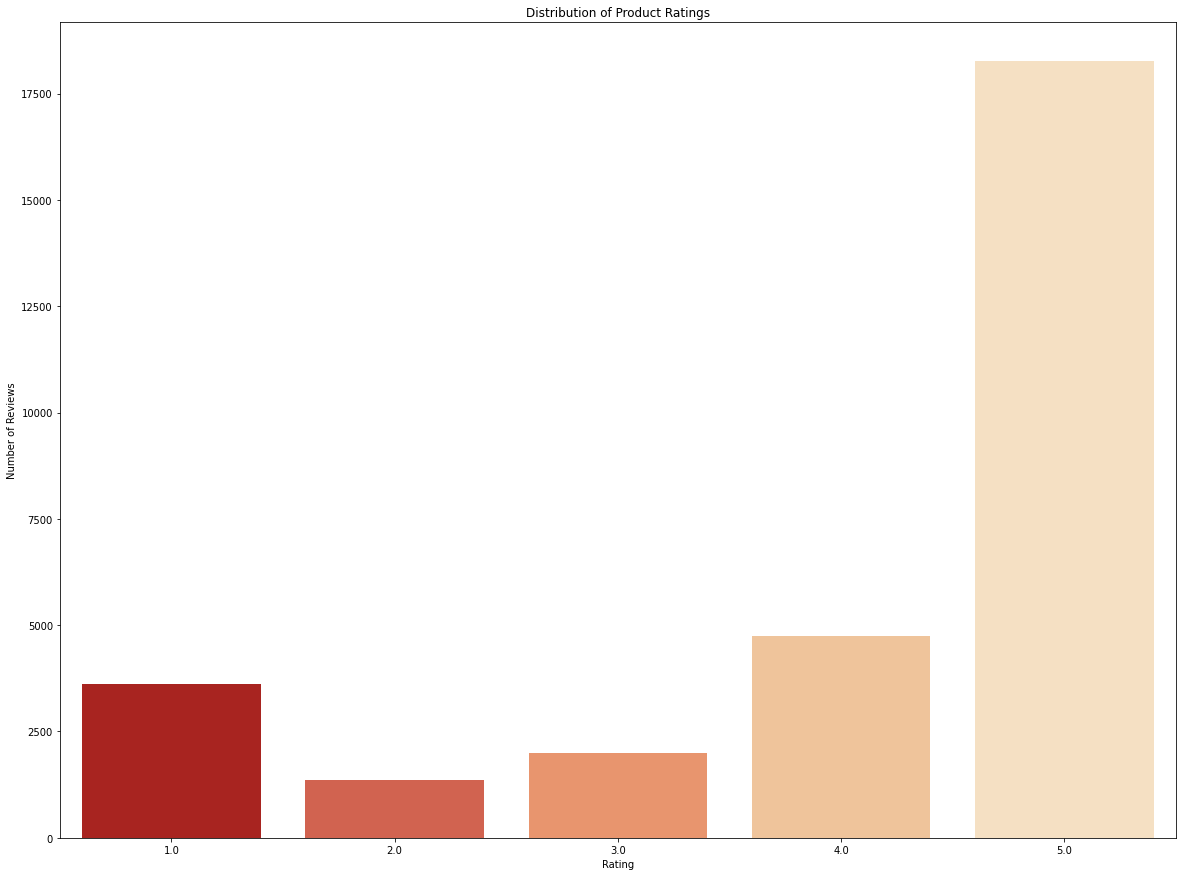

In [45]:
import seaborn as sns

f, axes = plt.subplots(figsize=(20,15))
ax = sns.countplot(x=review_df["Rating"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [46]:
majority = review_df["Rating"] == 5
majority_ratio = len(review_df[majority]) / len(df)

print(f"{majority_ratio*100:.2f}%")

60.88%


In [47]:
count = len(model_df[model_df["label"] == 2])
print(f"Size of the most underrepresented class: {count}")

Size of the most underrepresented class: 1368


In [48]:
#trim the majority class
condition = model_df["label"] == 5
trimmed_df = model_df[condition].sample(n=count, random_state=42)

#trim other class and add on to the trimmed_df
for rating in [1, 2, 3, 4]:
    condition = model_df["label"] == rating
    if len(model_df[condition]) >= count:
        add_df = model_df[condition].sample(n=count, random_state=42)
    else:
        add_df = model_df[condition]
    trimmed_df = pd.concat([trimmed_df, add_df], ignore_index=False)

#display new class sizes of trimmed_df
for rating in [1, 2, 3, 4, 5]:
    class_size = len(trimmed_df[trimmed_df["label"] == rating])
    print(f"Size of Class {rating}: {class_size}")

Size of Class 1: 1368
Size of Class 2: 1368
Size of Class 3: 1368
Size of Class 4: 1368
Size of Class 5: 1368


In [49]:
trimmed_df = trimmed_df.sort_values(by="label")
display(trimmed_df.head())

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,label
14211,-2.584235,-1.054543,0.677998,1.734447,0.213069,-0.520823,-1.512658,1.095272,-0.440422,0.655986,...,-0.150827,-1.902289,0.341546,-1.231446,-1.175420,-1.944539,1.221907,4.103431,0.650054,1.0
18740,-1.861931,-0.243257,1.436307,0.998393,-0.029781,0.043602,-0.759705,1.573526,0.411093,1.178154,...,0.083120,-1.470560,0.196092,-1.273309,-0.336894,-0.893601,1.069086,2.066955,0.641313,1.0
21853,-2.522502,-1.113262,0.698851,1.699083,0.547601,-0.149964,-0.867978,1.749554,-1.200817,0.285880,...,0.469192,-1.755782,1.352310,-2.353086,-1.281478,-1.384032,0.824065,3.156430,0.201140,1.0
12281,-1.052501,0.306683,0.916127,1.098875,0.122581,-0.315868,0.170880,0.638331,-0.134217,0.913103,...,0.065146,-0.776647,0.705138,-0.339934,-0.693458,-0.432574,0.253824,0.071718,0.909028,1.0
18320,-2.676740,-0.573689,0.840478,2.677358,-0.227385,-0.636735,-1.423520,1.300104,-0.547902,0.991026,...,-0.002987,-3.313780,1.407586,-4.285867,-1.724467,-2.941557,1.543400,4.786699,1.421002,1.0


[Text(0.5, 1.0, 'Distribution of Product Ratings after Underrepresentation'),
 Text(0.5, 0, 'Rating'),
 Text(0, 0.5, 'Number of Reviews')]

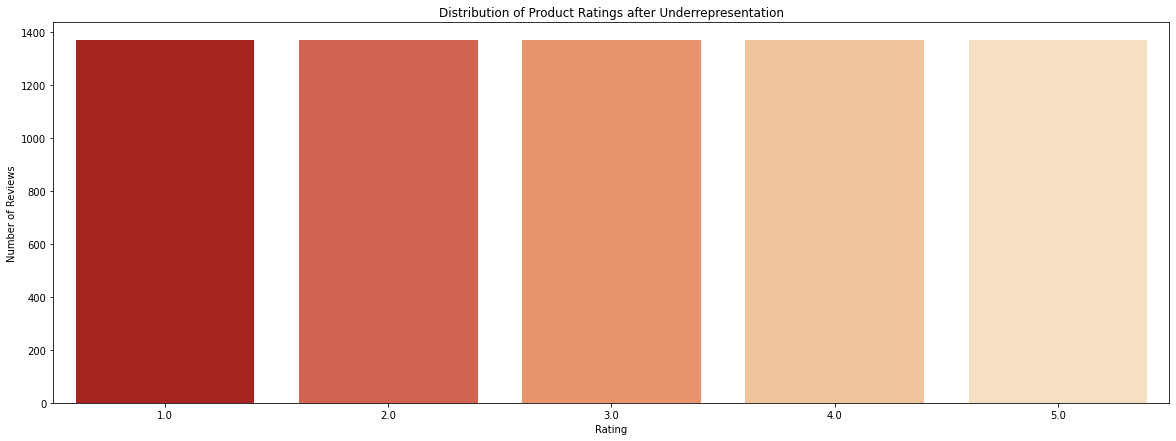

In [50]:
f, axes = plt.subplots(figsize=(20,7))
ax = sns.countplot(x=trimmed_df["label"], palette="OrRd_r")
ax.set(title="Distribution of Product Ratings after Underrepresentation", \
       xlabel="Rating", ylabel="Number of Reviews")
plt.show()

In [65]:
from sklearn.model_selection import train_test_split

X = trimmed_df.iloc[:, :-1]
y = trimmed_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [66]:
from sklearn import metrics

label_shape = np.shape(y_test)
y_baseline = np.full(label_shape, 5)

accuracy_baseline = metrics.accuracy_score(y_test, y_baseline)
f1_score_baseline = metrics.f1_score(y_test, y_baseline, average="micro")

print(f"Baseline Accuracy: {accuracy_baseline*100:.3f}%")
print(f"Baseline F1 Score: {f1_score_baseline:.3f}")

Baseline Accuracy: 19.981%
Baseline F1 Score: 0.200


In [67]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=25, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(class_weight={1: 10, 2: 12, 3: 7, 4: 9, 5: 1},
                       criterion='entropy', n_estimators=25, random_state=42)

In [68]:
y_pred = forest.predict(X_train)

accuracy = metrics.accuracy_score(y_train, y_pred)
f1_score = metrics.f1_score(y_train, y_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 96.658%
Training Set F1 Score: 0.967


[Text(0.5, 1.0, 'Confusion Matrix for Training Set'),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')],
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5')],
 Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Truth')]

Text(0, 0, '99.600%')

Text(1, 0, '0.100%')

Text(2, 0, '0.200%')

Text(3, 0, '0.100%')

Text(4, 0, '0.000%')

Text(0, 1, '1.100%')

Text(1, 1, '98.100%')

Text(2, 1, '0.500%')

Text(3, 1, '0.200%')

Text(4, 1, '0.000%')

Text(0, 2, '1.800%')

Text(1, 2, '0.200%')

Text(2, 2, '96.200%')

Text(3, 2, '1.600%')

Text(4, 2, '0.200%')

Text(0, 3, '1.500%')

Text(1, 3, '0.100%')

Text(2, 3, '1.100%')

Text(3, 3, '97.000%')

Text(4, 3, '0.300%')

Text(0, 4, '2.800%')

Text(1, 4, '0.200%')

Text(2, 4, '1.100%')

Text(3, 4, '3.400%')

Text(4, 4, '92.400%')

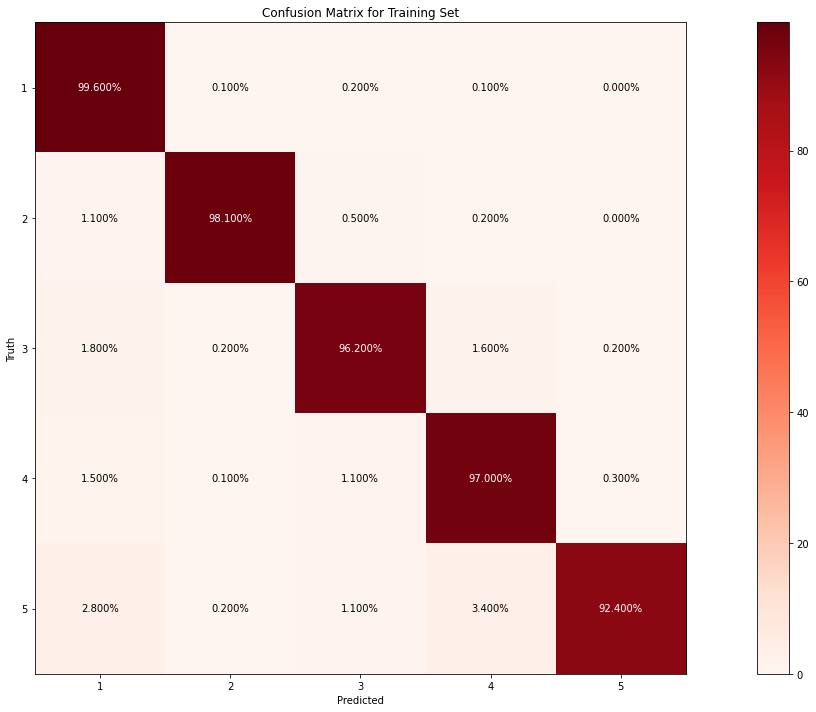

In [69]:
from sklearn.metrics import confusion_matrix

#create the confusion matrix of the training set
confusion_train = confusion_matrix(y_train, y_pred)
confusion_train = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im = axes.imshow(confusion_train, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train.shape[1]), \
         yticks=np.arange(confusion_train.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train.max()/1.5
for i in range(confusion_train.shape[0]):
    for j in range(confusion_train.shape[1]):
        axes.text(j, i, f"{confusion_train[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [70]:
# get the classification report
from sklearn.metrics import classification_report

predictions = forest.predict(X_test)
print(classification_report(y_test, predictions))
# Accuracy of the train and test dataset
print('Accuracy of the train dataset: {:.4f}'.format(forest.score(X_train, y_train)))
print('Accuracy of the test dataset: {:.4f}'.format(forest.score(X_test, y_test)))

              precision    recall  f1-score   support

         1.0       0.29      0.41      0.34       411
         2.0       0.24      0.23      0.23       410
         3.0       0.22      0.21      0.22       410
         4.0       0.29      0.25      0.27       411
         5.0       0.30      0.24      0.27       410

    accuracy                           0.27      2052
   macro avg       0.27      0.27      0.27      2052
weighted avg       0.27      0.27      0.27      2052

Accuracy of the train dataset: 0.9666
Accuracy of the test dataset: 0.2690


In [86]:
X1 = model_df.iloc[:, :-1]
y1 = model_df.iloc[:, -1]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=0.3, random_state=42)

In [87]:
forest1 = RandomForestClassifier(n_estimators=25, class_weight={1:10, 2:12, 3:7, 4:9, 5:1}, \
                                criterion="entropy", random_state=42)
forest1.fit(X_train, y_train)

RandomForestClassifier(class_weight={1: 10, 2: 12, 3: 7, 4: 9, 5: 1},
                       criterion='entropy', n_estimators=25, random_state=42)

In [88]:
y1_pred = forest1.predict(X1_train)

accuracy = metrics.accuracy_score(y1_train, y1_pred)
f1_score = metrics.f1_score(y1_train, y1_pred, average="micro")

print(f"Training Set Accuracy: {accuracy*100:.3f}%")
print(f"Training Set F1 Score: {f1_score:.3f}")

Training Set Accuracy: 37.182%
Training Set F1 Score: 0.372


[Text(0.5, 1.0, 'Confusion Matrix for Training Set'),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5')],
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5')],
 Text(0.5, 0, 'Predicted'),
 Text(0, 0.5, 'Truth')]

Text(0, 0, '9960.000%')

Text(1, 0, '10.000%')

Text(2, 0, '20.000%')

Text(3, 0, '10.000%')

Text(4, 0, '0.000%')

Text(0, 1, '110.000%')

Text(1, 1, '9810.000%')

Text(2, 1, '50.000%')

Text(3, 1, '20.000%')

Text(4, 1, '0.000%')

Text(0, 2, '180.000%')

Text(1, 2, '20.000%')

Text(2, 2, '9620.000%')

Text(3, 2, '160.000%')

Text(4, 2, '20.000%')

Text(0, 3, '150.000%')

Text(1, 3, '10.000%')

Text(2, 3, '110.000%')

Text(3, 3, '9700.000%')

Text(4, 3, '30.000%')

Text(0, 4, '280.000%')

Text(1, 4, '20.000%')

Text(2, 4, '110.000%')

Text(3, 4, '340.000%')

Text(4, 4, '9240.000%')

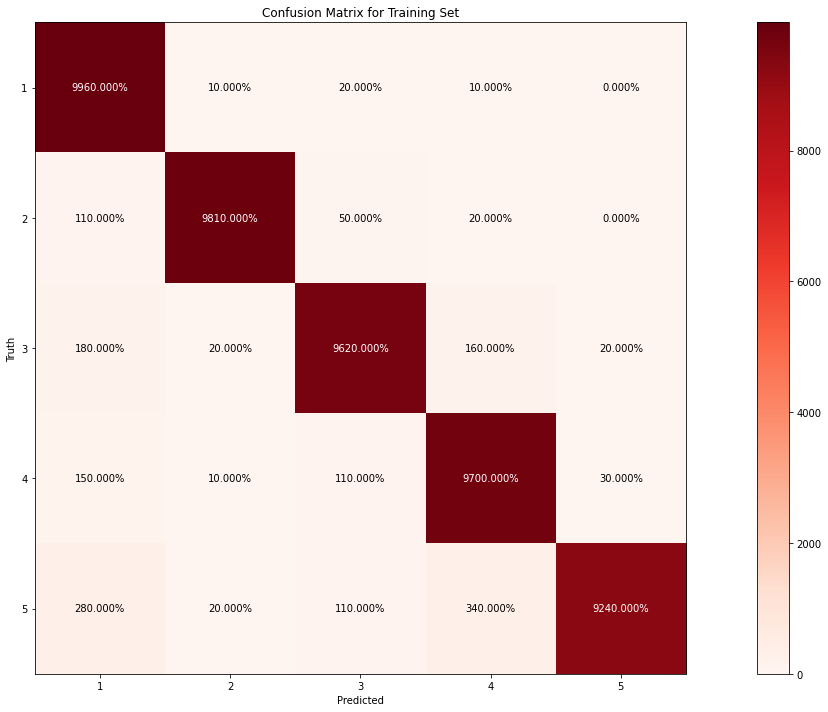

In [89]:
#create the confusion matrix of the training set
confusion_train1 = confusion_matrix(y1_train, y1_pred)
confusion_train1 = confusion_train.astype("float") / \
                   confusion_train.sum(axis=1)[:, np.newaxis]
confusion_train1 = np.around(confusion_train, decimals=3)*100

#create confusion matrix heat map
f, axes = plt.subplots(figsize=(20,10))
im1 = axes.imshow(confusion_train1, interpolation="nearest", cmap=plt.cm.Reds)

axes.figure.colorbar(im1, ax=axes)
axes.set(title="Confusion Matrix for Training Set", \
         xticks=np.arange(confusion_train1.shape[1]), \
         yticks=np.arange(confusion_train1.shape[0]), \
         xticklabels=range(1, 6), yticklabels=range(1, 6), \
         xlabel="Predicted", ylabel="Truth")

#add clear annotations to the confusion matrix
threshold = confusion_train1.max()/1.5
for i in range(confusion_train1.shape[0]):
    for j in range(confusion_train1.shape[1]):
        axes.text(j, i, f"{confusion_train1[i, j]:.3f}%",
                ha="center", va="center",
                color="white" if confusion_train1[i, j] > threshold else "black")
f.tight_layout()
plt.show()

In [90]:
predictions1 = forest1.predict(X1_test)
print(classification_report(y1_test, predictions1))
# Accuracy of the train and test dataset
print('Accuracy of the train dataset: {:.4f}'.format(forest1.score(X1_train, y1_train)))
print('Accuracy of the test dataset: {:.4f}'.format(forest1.score(X1_test, y1_test)))

              precision    recall  f1-score   support

         1.0       0.21      0.39      0.27      1087
         2.0       0.18      0.75      0.29       411
         3.0       0.21      0.59      0.31       595
         4.0       0.29      0.39      0.33      1426
         5.0       0.78      0.25      0.37      5479

    accuracy                           0.33      8998
   macro avg       0.34      0.47      0.32      8998
weighted avg       0.57      0.33      0.35      8998

Accuracy of the train dataset: 0.3718
Accuracy of the test dataset: 0.3311


In [ ]:
class Text_Prepocessing:
    
    def ___init___(self, dataframe, string, string_list = []):
        self.dataframe = dataframe
        self.string = string
        self.string_list = string_list
    
    def df_dropna(self):
        return self.dataframe.dropna()
    
    def decontraction(self):
        '''expand the short forms, expecailly "'ve" to have that can not achieve in the sapcy'''
        return contractions.fix(self.string)
    
    def multiple_spaces_remover(self):
        '''remove multiple spaces in the comments'''
        result = " ".join(self.string.split())
        print("after multiple_spaces_remover", result)
        return result
#         return " ".join(self.string.split())
    
    def URL_remover(self):
        '''remove URLs in the text; pattern has been defined above'''
        return re.sub(pattern, '', self.string)
    
    def accented_chars_remover(self):
        '''remove accented_chars of each comment'''
        return remove_acc_data(self.string)
    
    def punctuations_remover(self):
        '''remove the punctuations of each comment'''
#         punct_string_list = []
        for token in self.string:
            if token.text not in revised_punct:
                return token
    
    def stopwords_remover(self):
#         stpw_string = []
        for token in self.string:
            if token.text not in stopwords:
                self.string_list.append(token)
            return self.string_list
        
    def lemmatization(self):
        for token in self.string:
            if token.lemma_ == '-JJR-' or '-JJS-' or '-RBR-' or '-RBS-':
                return token.lower_
            else: 
                return word.lemma_.lower()
    
    def combine(self, string):
        string = multiple_spaces_remover(string)
        print("after multiple_spaces_remover", string)
        string = URL_remover(string)
        string = accented_chars_remover(string)
        string = multiple_spaces_remover(string)
        string = multiple_spaces_remover(string)
        
    
                